# Machine Learning regression models to predict binding affinity of SARS-CoV-2 inhibitors

Caio Cedrola Rocha, Leonardo Goliatt Fonseca, Diego E. B Gomes


In [1]:
# Step 1 - Load python modules
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Step 2 - Read SARS-CoV-2 Main activity data
activities = pd.read_csv('activity_data.csv')

# Step 3 - Filter activities.
data = activities#.query('f_avg_IC50 < 10')
#data = activities

In [3]:
# Activity data comes as IC50.
# To keep it simple we need to convert it to DeltaG in kcal/mol.

# To convert from micro-Molar to dG I'll apply the following formula.
# dG = RTln(IC50)

#R=8.3144621 # J mol-1 K-1
R=1.987E-3 # cal mol-1 K-1
T=298.15   # Temperature

# Example for 1micro-Molar
dG = R*T*np.log(1E-6) 
print(f'{dG:.2f}kcal/mol')

-8.18kcal/mol


In [4]:
# Apply the formula to our DataFrame
data['dG'] = data['f_avg_IC50'].apply(lambda x: R*T*np.log(x/100000))

## Data exploration

<AxesSubplot:xlabel='f_avg_IC50', ylabel='Count'>

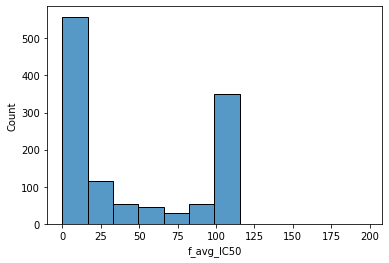

In [5]:
# As you can see, LOTS of compounds are "inactive".
sns.histplot(data['f_avg_IC50'])

<AxesSubplot:xlabel='dG', ylabel='Count'>

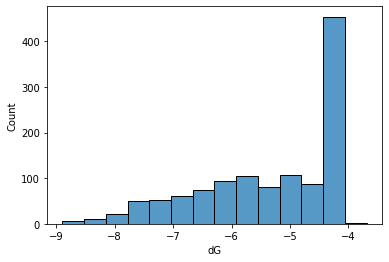

In [6]:
sns.histplot(data['dG'])

In [7]:
data[['SMILES','CID']].to_csv('smiles.smi',index=False)

In [8]:
from rdkit import Chem
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

mols = [Chem.MolFromSmiles(smi) for smi in data['SMILES']]

In [9]:
# Get list of descriptors
descriptors_list = [a[0] for a in Chem.Descriptors.descList]
calculator = MolecularDescriptorCalculator(descriptors_list)
calc_descriptors = [calculator.CalcDescriptors(m) for m in mols]

In [10]:
df = pd.DataFrame(calc_descriptors, columns=descriptors_list)

In [11]:
df.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,14.135814,-1.022707,14.135814,0.116928,0.308873,555.075,519.795,554.229598,208,0,...,0,0,0,0,0,0,0,0,0,0
1,13.490509,-3.779742,13.490509,0.010989,0.587016,485.993,461.801,485.117605,172,0,...,0,1,0,0,0,0,0,0,0,0
2,14.114299,-1.016449,14.114299,0.176777,0.265548,541.007,515.807,540.156433,196,0,...,0,0,0,0,0,0,0,0,1,0
3,14.256120,-1.003594,14.256120,0.144602,0.273005,592.100,557.828,591.236080,220,0,...,0,0,0,0,0,0,0,0,0,0
4,13.843030,-0.460244,13.843030,0.198219,0.510128,450.905,430.745,450.137115,162,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Compute the correlation matrix
corr = df.corr().abs()

# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
# Create correlation matrix

# Select upper triangle of correlation matrix
value=0.5
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find features with correlation greater than "value"
to_drop = [column for column in upper.columns if any(upper[column] > value)]

# Drop features 
df.drop(df[to_drop], axis=1,inplace=True)

In [13]:
df.head()

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_MRLOW,BalabanJ,...,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfone,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,14.135814,-1.022707,0.116928,0,0.407416,-0.493219,35.495692,9.743588,-0.122147,1.591030,...,1,0,0,0,0,0,0,0,0,0
1,13.490509,-3.779742,0.010989,0,0.232833,-0.391723,35.495692,9.897554,-0.117524,1.496747,...,1,0,0,0,0,0,0,0,0,0
2,14.114299,-1.016449,0.176777,0,0.261088,-0.493219,35.495692,9.744026,-0.122135,1.253495,...,1,0,0,0,0,0,0,0,1,0
3,14.256120,-1.003594,0.144602,0,0.407477,-0.493219,35.495693,9.743836,-0.122146,1.387895,...,1,0,0,0,0,0,0,0,0,0
4,13.843030,-0.460244,0.198219,0,0.232793,-0.323637,35.495692,9.884614,-0.117949,1.459156,...,1,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

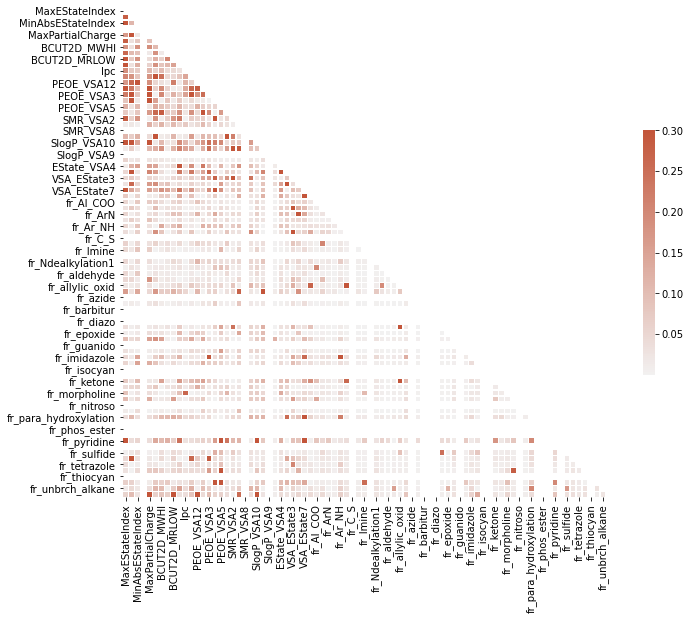

In [14]:
# Re-Compute the correlation matrix
corr = df.corr().abs()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [15]:
df.insert(0, column='CID', value=data['CID'].tolist())
df.insert(0, column='dG', value=data['dG'].tolist())

In [16]:
df.dropna(inplace=True)

In [17]:
df.columns[2:]

Index(['MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex',
       'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge',
       'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_MRLOW', 'BalabanJ', 'Ipc',
       'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA3', 'PEOE_VSA4',
       'PEOE_VSA5', 'PEOE_VSA9', 'SMR_VSA2', 'SMR_VSA4', 'SMR_VSA8',
       'SMR_VSA9', 'SlogP_VSA10', 'SlogP_VSA4', 'SlogP_VSA9', 'EState_VSA11',
       'EState_VSA4', 'EState_VSA7', 'VSA_EState3', 'VSA_EState4',
       'VSA_EState7', 'NumAliphaticCarbocycles', 'fr_Al_COO', 'fr_Al_OH',
       'fr_ArN', 'fr_Ar_COO', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_C_S', 'fr_HOCCN',
       'fr_Imine', 'fr_N_O', 'fr_Ndealkylation1', 'fr_SH', 'fr_aldehyde',
       'fr_alkyl_carbamate', 'fr_allylic_oxid', 'fr_aryl_methyl', 'fr_azide',
       'fr_azo', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo',
       'fr_dihydropyridine', 'fr_epoxide', 'fr_furan', 'fr_guanido',
       'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan',
     

In [18]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 0].values

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=20, random_state=42)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

In [22]:
from sklearn import metrics

print(f' MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f' MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
#print(" RF - Accuracy: %.2f%%" % (accuracy * 100.0))

 MAE: 0.73
 MSE: 0.95
RMSE: 0.97


/Users/dgomes/miniconda3/envs/modmol/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'dG pred')

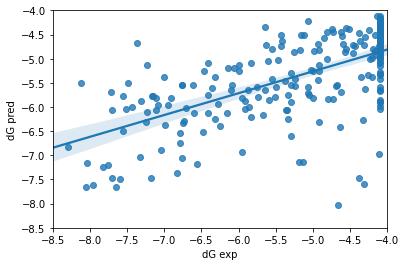

In [23]:
sns.regplot(y_test,y_pred)
plt.xlim(-8.5,-4)
plt.ylim(-8.5,-4)
plt.xlabel('dG exp')
plt.ylabel('dG pred')

/Users/dgomes/miniconda3/envs/modmol/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'dG pred')

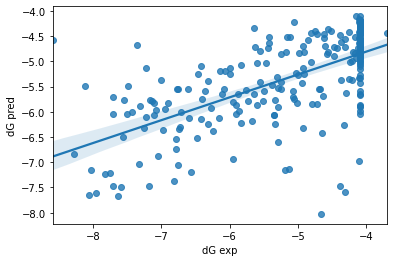

In [24]:
sns.regplot(y_test,y_pred)
#plt.xlim(-10.0,-5.5)
#plt.ylim(-10.0,-5.5)
plt.xlabel('dG exp')
plt.ylabel('dG pred')

In [25]:
# XGBoost

In [26]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

/Users/dgomes/miniconda3/envs/modmol/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

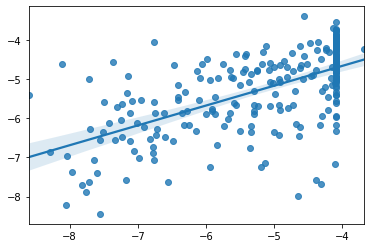

In [27]:
sns.regplot(y_test,y_pred)

In [28]:
from sklearn import metrics

print(f' MAE: {metrics.mean_absolute_error(y_test, y_pred):.2f}')
print(f' MSE: {metrics.mean_squared_error(y_test, y_pred):.2f}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred)):.2f}')
#print(" RF - Accuracy: %.2f%%" % (accuracy * 100.0))

 MAE: 0.75
 MSE: 1.05
RMSE: 1.02


In [29]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(XGBRegressor(objective='reg:squarederror'), X, y, scoring='neg_mean_squared_error')
(-scores)**0.5

array([1.33424282, 1.03636409, 1.03187722, 1.22894166, 0.92140236])

In [30]:
importances = rfr.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rfr.estimators_], axis=0)


In [31]:
feature_names = [f'feature {i}' for i in range(X.shape[1])]


In [32]:
len(descriptors_list)
len(feature_names)

82

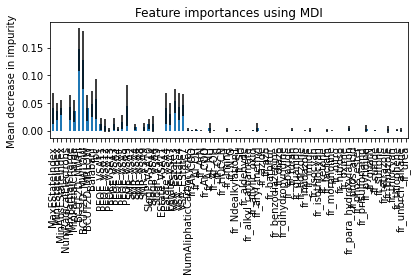

In [33]:
forest_importances = pd.Series(importances, index=df.columns[2:])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [36]:
a = pd.DataFrame(forest_importances).reset_index().sort_values(0,ascending=False)

<AxesSubplot:xlabel='index'>

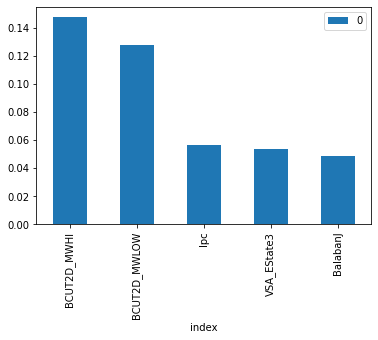

In [49]:
a.head().plot(x='index',y=0,kind='bar')

In [45]:
a

,index,0
6,BCUT2D_MWHI,0.147233
7,BCUT2D_MWLOW,0.127733
10,Ipc,0.056663
28,VSA_EState3,0.053747
9,BalabanJ,0.048549
...,...,...
50,fr_barbitur,0.000000
56,fr_guanido,0.000000
51,fr_benzodiazepine,0.000000
54,fr_epoxide,0.000000
